In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np
import re, os, sarge
from pybedtools import BedTool
%matplotlib inline
plt.style.use('ggplot')

In [3]:
ref_id_fn = '/data/genome/hamster/ncbi_refseq/hamster_all_id.txt'
path = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie'
mouse_pr_fn = '/data/genome/mouse/mouse_pr_blastDb/gencode.vM17.pc_translations.fa'

thread = 19
transde_path = path + '/transdecoder'
dft2ref_pr = transde_path + '/map2hamster.txt'
dft2uni_pr = transde_path + '/map2uniprot.txt'
ref_pr_fn = path + '/hamster_pr.fa'
uni_pr_fn = path + '/uniprot_sprot.fasta'
dft_pr_fn = path + '/03_pasa_stringtie_pr.fa'
dft_gff_fn = path + '/03_pasa_stringtie.gff3'
chr_pr_fn = path + '/Nicole_hamster_pr.fa'
k1_pr_fn = path + '/chok1_pr.fa'

In [5]:
# unique protein sequences
dft_pep_pr_dic = {}
for record in SeqIO.parse(dft_pr_fn, 'fasta'):
    seq = str(record.seq)
    if seq in dft_pep_pr_dic:
        dft_pep_pr_dic[seq].append(record.id)
    else:
        dft_pep_pr_dic[seq] = [record.id]
dft_prs = [v[0] for v in dft_pep_pr_dic.values()]

In [140]:
print len(dft_prs)

47829


In [8]:
ref_pep_pr_dic = {}
for record in SeqIO.parse(ref_pr_fn, 'fasta'):
    seq = str(record.seq)
    if seq in ref_pep_pr_dic:
        ref_pep_pr_dic[seq].append(record.id)
    else:
        ref_pep_pr_dic[seq] = [record.id]
ref_prs = [v[0] for v in ref_pep_pr_dic.values()]

In [7]:
# index = SeqIO.index(dft_pr_fn,'fasta')
# with open('/home/shangzhong/dft_uniq_pr.fa','w') as f:
# #     for p in set(dft_prs) - set(perfect_draft_proteins) - set(perfect_draft_only_prs) - set(perfect_ref_only_prs):
#     for p in set(dft_prs) - set(perfect_draft_proteins):
#         SeqIO.write(index[p],f,'fasta')

In [9]:
len(ref_prs)

28748

### Map draft proteins and hamster refseq to mouse proteins

In [10]:
def makeblastdb(fastaFile,datatype,out_path,outputname):
    """
    this function build database given a fasta file
    * fastaFile: can be gzipped or not
    """
    if not os.path.exists(out_path):os.mkdir(out_path)
    os.chdir(out_path)
    cmd = ('makeblastdb -in {input} -dbtype {type} -title {title} -out {outputname}').format(
        input=fastaFile,type=datatype,outputname=outputname,title=outputname)
    sarge.run(cmd)
    
def blastp(query,outputFile,database,thread,mapnum=1):
    """
    This function run blastp
    * query: fasta file which you want to map
    * database: database path/name
    * outputFile: tabular blast result
    """
    cmd = ('blastp -query {inf} -db {database} -out {outputFile} '
           '-evalue 1e-4 -outfmt \'6 qacc sacc pident length mismatch '
           'gapopen qstart qend sstart send evalue bitscore qlen slen\' '
           '-num_threads {thread} -num_alignments {mapnum}').format(inf=query,
                database=database,outputFile=outputFile,thread=str(thread),mapnum=str(mapnum))
    sarge.run(cmd)

def blastn(query,outputFile,database,thread,mapnum=1):
    ''''''
    cmd = ('blastn -query {inf} -db {database} -out {out} -evalue 1e-4 '
           '-outfmt \'6 qacc sacc pident length mismatch '
           'gapopen qstart qend sstart send evalue bitscore qlen slen\' '
          '-num_threads {thread} -num_alignments {mapnum}').format(inf=query,
                database=database,out=outputFile,thread=str(thread),mapnum=str(mapnum))
    sarge.run(cmd)

dft2mouse_fn = path + '/11_draft2mouse.txt'
ref2mouse_fn = path + '/11_refseq2mouse.txt'

db_path = os.path.dirname(mouse_pr_fn)
if not os.path.exists(db_path):
    os.mkdir(db_path)
    makeblastdb(mouse_pr_fn, 'prot', db_path, 'mouse')
if not os.path.exists(dft2mouse_fn):
    blastp(dft_pr_fn, dft2mouse_fn, db_path+'/mouse', thread)
if not os.path.exists(ref2mouse_fn):
    blastp(ref_pr_fn, ref2mouse_fn, db_path+'/mouse', thread)

In [11]:
# map refseq protein to draft protein
dft_db_path = path + '/dft_pr_blastDb'
ref2dft_fn = path + '/12_refseq2draft.txt'
if not os.path.exists(dft_db_path):
    os.mkdir(dft_db_path)
    makeblastdb(dft_pr_fn, 'prot', dft_db_path, 'draft')
if not os.path.exists(ref2dft_fn):
    blastp(ref_pr_fn, ref2dft_fn, dft_db_path+'/draft', thread)

In [12]:
# map draft protein to nicole hamster proteins
chr_db_path = path + '/nicole_pr_blastDb'
dft2chr_fn = path + '/13_draft2nicole.txt'
if not os.path.exists(chr_db_path):
    os.mkdir(chr_db_path)
    makeblastdb(chr_pr_fn, 'prot', chr_db_path, 'chr')
if not os.path.exists(dft2chr_fn):
    blastp(dft_pr_fn, dft2chr_fn, chr_db_path+'/chr', thread)
# map draft to chok1
k1_db_path = path + '/chok1_pr_blastDb'
dft2k1_fn = path + '/14_draft2chok1.txt'
if not os.path.exists(k1_db_path):
    os.mkdir(k1_db_path)
    makeblastdb(k1_pr_fn, 'prot', k1_db_path, 'k1')
if not os.path.exists(dft2k1_fn):
    blastp(dft_pr_fn, dft2k1_fn, k1_db_path+'/k1', thread)

In [13]:
def draft_all_id(draft_gff):
    '''
    draft_gff: annotation file of draft annotation.
    '''
    gff_df = pd.read_csv(draft_gff,sep='\t',header=None)
    rna_df = gff_df[gff_df[2].values=='mRNA']
    rna_df = rna_df.reset_index(drop=True)
    rna_df['geneid'] = rna_df[8].map(lambda x: re.search('(?<=gene_id=).+?(?=;)',x).group(0))
    rna_df['gename'] = rna_df[8].map(lambda x: re.search('(?<=Name=).+?(?=;|$)',x).group(0))
    rna_df['rna_id'] = rna_df[8].map(lambda x: re.search('(?<=ID=).+?(?=;)',x).group(0))
    rna_df = rna_df[['rna_id','geneid','gename']]
    rna_gid_dic = rna_df.set_index('rna_id')['geneid'].to_dict()
    rna_gnm_dic = rna_df.set_index('rna_id')['gename'].to_dict()
    gid_rna_dic = {k:list(v) for k,v in rna_df.groupby('geneid')['rna_id']}
    return rna_df, rna_gid_dic, rna_gnm_dic, gid_rna_dic

# prepare all id dictionary
dft_rna_id_df, dft_rna_gid_dic, dft_rna_gnm_dic, dft_gid_rna_dic = draft_all_id(dft_gff_fn)

In [14]:
def get_pr_id_dic(fa):
    '''get dictionary {pr_seq : [pr1, pr2]}'''
    dic = {}
    for record in SeqIO.parse(fa, 'fasta'):
        seq = str(record.seq)
        if seq in dic:
            dic[seq].append(record.id)
        else: 
            dic[seq] = [record.id]
    return dic

dft_pr_id_dic = get_pr_id_dic(dft_pr_fn)

In [15]:
# get hamster refseq id
ref_id_df = pd.read_csv(ref_id_fn, sep='\t', header=0)
ref_id_df['PrAccess'] = ref_id_df['PrAccess'].map(lambda x: x.split('.')[0])
ref_pr_gid_dic = ref_id_df.set_index('PrAccess')['GeneID'].to_dict()
ref_genes = ref_id_df[ref_id_df['PrAccess'].values != '-']['GeneID'].unique().tolist()
print 'there are', len(ref_genes), 'genes in refseq'

there are 20350 genes in refseq


In [16]:
def get_pr_len(fn, rm_v=False):
    '''rm_v means remove version infor in protein id'''
    dic = {}
    for record in SeqIO.parse(fn,'fasta'):
        dic[record.id] = len(record.seq)
    if rm_v == True:
        for k in dic:
            new = k.split('.')[0]
            dic[new] = dic.pop(k)
    return dic
ref_pr_len_dic = get_pr_len(ref_pr_fn,True)
uni_pr_len_dic = get_pr_len(uni_pr_fn)
dft_pr_len_dic = get_pr_len(dft_pr_fn)
mouse_pr_len_dic = get_pr_len(mouse_pr_fn)
chr_pr_len_dic = get_pr_len(chr_pr_fn,True)
k1_pr_len_dic = get_pr_len(k1_pr_fn,True)
# many rnas don't have proteins
dft_rna_id_df['pr_len'] = dft_rna_id_df['rna_id'].map(lambda x: dft_pr_len_dic[x] if x in dft_pr_len_dic else 0)
dft_pr_id_df = dft_rna_id_df.query('pr_len != 0').reset_index(drop=True)

In [17]:
print 'there are', len(ref_pr_len_dic), 'hamster refseq proteins'
print 'there are', len(uni_pr_len_dic), 'uniprot proteins'
print 'there are', len(dft_pr_len_dic), 'draft proteins'
print 'there are', len(chr_pr_len_dic), 'chromo proteins'
print 'there are', len(k1_pr_len_dic),  'chok1 proteins'

there are 32836 hamster refseq proteins
there are 556006 uniprot proteins
there are 63331 draft proteins
there are 29144 chromo proteins
there are 34925 chok1 proteins


In [18]:
# Get perfect map between draft and hamster refseq
perfect_draft_protein_fn = path+'/13_perfect_draft_prs2refseq.txt'  # this file was got using code get_perfect_pr_map
perfect_draft_protein_df = pd.read_csv(perfect_draft_protein_fn,sep='\t',header=None,names=['draft','PrAccess'])
perfect_draft_protein_df['PrAccess'] = perfect_draft_protein_df['PrAccess'].map(lambda x: x.split('.')[0])
perfect_draft_protein_df = pd.merge(perfect_draft_protein_df, ref_id_df[['PrAccess','GeneID']], on='PrAccess', how='inner')
perfect_draft_proteins = list(set(perfect_draft_protein_df['draft'].unique().tolist()).intersection(dft_prs))
perfect_ref_proteins = perfect_draft_protein_df['PrAccess'].unique().tolist()
perfect_ref_genes = perfect_draft_protein_df['GeneID'].unique().tolist()
print 'there are', len(perfect_draft_proteins), 'perfect mapping between draft and refseq',\
    'mapping to', len(perfect_ref_proteins), 'refseq proteins', len(perfect_ref_genes),'genes'

there are 15787 perfect mapping between draft and refseq mapping to 17393 refseq proteins 11038 genes


### Till this step, we mapped 33% proteins, 54% genes
Next we check proteins that perfectly map, but draft protein is either shorter or longer than refseq, we check if their isoforms are exactly the same with refseq

#### 1. One side Perfect match between draft annotation and refseq
In total, there are 63331 proteins, 47829 unique protein sequences

In [19]:
def get_pr_map_df(fn, draft_prs, query_len_dic=''):
    '''
    gets mappings of draft_prs.
    '''
    map2ham_pr_df = pd.read_csv(fn,sep='\t',header=None,names=['query','ref','pident',
                        'length','mm','gap','qs','qe','ss','se','evalue','bitscore','qlen','slen'])
    map2ham_pr_df['query'] = map2ham_pr_df['query'].map(lambda x: x.split('.')[0])
    map2ham_pr_df['ref'] = map2ham_pr_df['ref'].map(lambda x: x.split('.')[0])
    map2ham_pr_df = map2ham_pr_df.query('query in @draft_prs')
    map2ham_pr_df = map2ham_pr_df.reset_index(drop=True)
    if query_len_dic != '':
        map2ham_pr_df['qlen'] = map2ham_pr_df['query'].map(lambda x: query_len_dic[x])
#     map2ham_pr_df['slen'] = map2ham_pr_df['ref'].map(lambda x: len_dic[x])
#     map2ham_pr_df['qlen'] -= 1
    map2ham_pr_df['q_per'] = (map2ham_pr_df['qe'] - map2ham_pr_df['qs']+1)/map2ham_pr_df['qlen']
    map2ham_pr_df['s_per'] = (map2ham_pr_df['se'] - map2ham_pr_df['ss']+1)/map2ham_pr_df['slen']
    return map2ham_pr_df

In [20]:
dft2ref_pr_df = get_pr_map_df(dft2ref_pr, dft_prs, dft_pr_len_dic)
dft2ref_pr_df['ref'] = dft2ref_pr_df['ref'].map(lambda x: x.split('.')[0])
dft2uni_pr_df = get_pr_map_df(dft2uni_pr, dft_pr_len_dic.keys())

fil_dft2ref_pr_df = dft2ref_pr_df.query('query not in @perfect_draft_proteins')
fil_dft2ref_pr_df = fil_dft2ref_pr_df.reset_index(drop=True)

In [21]:
def get_best_hit(df):
    idx = df.groupby(['query','ref'])['evalue'].transform(min) == df['evalue']
    df = df[idx]
    df = df.reset_index(drop=True)
    idx = df.groupby(['query','ref'])['bitscore'].transform(max) == df['bitscore']
    df = df[idx]
    df = df.reset_index(drop=True)
    return df

In [13]:
# perfect_pr_df = map2ham_pr_df.query('(pident == 100) & (q_per ==1) & (s_per == 1)')
# perfect_pr_df = perfect_pr_df.reset_index(drop=True)
# perfect_draft_prs = perfect_pr_df['query'].unique().tolist()
# perfect_ref_prs = perfect_pr_df['ref'].unique().tolist()
# perfect_ham_genes = ham_id_df.query('PrAccess in @perfect_ref_prs')['GeneID'].unique().tolist()
# print 'perfect match to hamster refseq:', len(perfect_draft_prs), 'draft prs mapping to', len(perfect_ref_prs),'refseq prs',\
#         len(perfect_ham_genes), 'refseq genes'

In [22]:
# perfect query mapping
perfect_draft_only_pr_df = fil_dft2ref_pr_df.query('(pident==100) & (q_per==1) & (s_per<1)')
perfect_draft_only_prs = perfect_draft_only_pr_df['query'].unique().tolist()
print 'perfect match, draft is shorter than refeq:', len(perfect_draft_only_prs), \
            'prs mapping to', perfect_draft_only_pr_df['ref'].unique().size,'refseq prs'
# perfect query mapping
perfect_ref_only_pr_df = fil_dft2ref_pr_df.query('(pident==100) & (q_per<1) & (s_per==1)')
perfect_ref_only_prs = perfect_ref_only_pr_df['query'].unique().tolist()
print 'perfect match, draft is longer than refeq:', len(perfect_ref_only_prs), \
            'prs mapping to', perfect_ref_only_pr_df['ref'].unique().size,'refseq prs'
one_side_perfect_dft_prs = list(set(perfect_draft_only_prs + perfect_ref_only_prs))
# get the proteins and refseq genes
one_side_perfect_ref_prs = perfect_draft_only_pr_df['ref'].unique().tolist() + perfect_ref_only_pr_df['ref'].unique().tolist()
one_side_perfect_ref_genes = ref_id_df.query('PrAccess in @one_side_perfect_ref_prs')['GeneID'].unique().tolist()
print len(set(one_side_perfect_ref_genes + perfect_ref_genes)),'refseq genes'

perfect match, draft is shorter than refeq: 3336 prs mapping to 3034 refseq prs
perfect match, draft is longer than refeq: 4147 prs mapping to 3622 refseq prs
13779 refseq genes


In [23]:
%%time
def find_iso_perfect(only_prs, perfect_prs, rna_gid_dic, gid_rna_dic):
    '''for these proteins, at least one of their isoform is exactly the same with refseq
    '''
    prs = []
    for pr in only_prs:
        gid = rna_gid_dic[pr]
        for rna in gid_rna_dic[gid]:
            if rna in perfect_prs:
                prs.append(pr)
                break
    return prs

draft_iso_short_perfect_prs = find_iso_perfect(perfect_draft_only_prs, perfect_draft_proteins, dft_rna_gid_dic, dft_gid_rna_dic)
draft_iso_long_perfect_prs = find_iso_perfect(perfect_ref_only_prs, perfect_draft_proteins, dft_rna_gid_dic, dft_gid_rna_dic)
print 'perfect draft shorter with isoform perfect mapping', len(draft_iso_short_perfect_prs)
print 'perfect draft longer with isoform perfect mapping', len(draft_iso_long_perfect_prs)
draft_iso_short_no_perfect_prs = list(set(perfect_draft_only_prs)-set(draft_iso_short_perfect_prs))
draft_iso_long_no_perfect_prs = list(set(perfect_ref_only_prs)-set(draft_iso_long_perfect_prs))
draft_iso_short_no_perfect_df = perfect_draft_only_pr_df.query('query == @draft_iso_short_no_perfect_prs')
draft_iso_long_no_perfect_df = perfect_ref_only_pr_df.query('query == @draft_iso_long_no_perfect_prs')

perfect draft shorter with isoform perfect mapping 1748
perfect draft longer with isoform perfect mapping 1656
CPU times: user 18 s, sys: 0 ns, total: 18 s
Wall time: 18 s


### Till this step, 23270 draft, 49% proteins, 68% refseq genes.

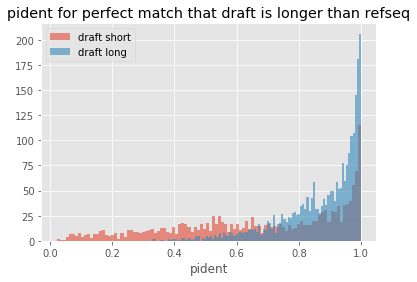

In [24]:
ax = perfect_draft_only_pr_df.query('query in @draft_iso_short_no_perfect_prs')['s_per'].hist(bins=100,alpha=0.6,label='draft short')
_ = ax.set_title('pident for perfect match that draft is shorter than refseq')
ax = perfect_ref_only_pr_df.query('query in @draft_iso_long_no_perfect_prs')['q_per'].hist(bins=100,alpha=0.6,label='draft long')
_ = ax.set_title('pident for perfect match that draft is longer than refseq')
_ = ax.set_xlabel('pident')
_ = plt.legend()

#### Compare with mouse proteins
1. map draft protein to mouse proteins
2. map refseq proteins to mouse proteins
3. compare the mapping results

In [25]:
dft2mouse_fn = path + '/11_draft2mouse.txt'
ref2mouse_fn = path + '/11_refseq2mouse.txt'

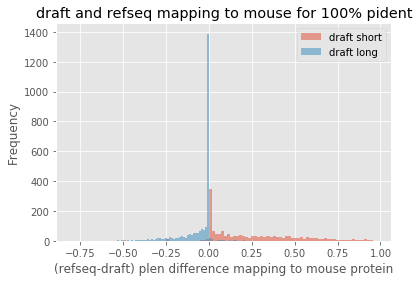

In [26]:
def get_merge_draft_refseq2mouse(one_side_perfect_df,draft2mouse_fn, refseq2mouse_fn, prs, ham_pr_len_dic):
    '''merge draft2refseq and refseq to mouse
    * one_side_perfect_df: blastp mapping of draft to refseq
    * draft2mouse_fn: blastp results of draft2mouse
    * refseq2mouse_fn: blastp results of refseq2mouse
    * prs: protein ids want to consider.
    * ham_pr_len_dic: refseq protein length dictionary
    '''
    draft2mouse_df = get_pr_map_df(draft2mouse_fn, prs)
    draft2mouse_df = get_best_hit(draft2mouse_df)
    refseq2mouse_df = get_pr_map_df(refseq2mouse_fn, ham_pr_len_dic.keys())
    refseq2mouse_df = get_best_hit(refseq2mouse_df)
    merge_draft2ref_mouse_df = pd.merge(one_side_perfect_df, draft2mouse_df, on='query',how='inner') # merge based on draft
    merge_draft2ref_mouse_df = merge_draft2ref_mouse_df.rename(columns={'query':'draft', 'ref_x':'query','ref_y':'mouse'}) # merge based on refseq
    merge_draft2ref_mouse_df = pd.merge(merge_draft2ref_mouse_df, refseq2mouse_df, on='query', how='inner')
    merge_draft2ref_mouse_df['mouse_match'] = merge_draft2ref_mouse_df['mouse'] == merge_draft2ref_mouse_df['ref']
    merge_draft2ref_mouse_df['diff'] = merge_draft2ref_mouse_df['s_per'] - merge_draft2ref_mouse_df['s_per_y']
    def ref_is_good(row):
        '''this one test if refeq mapping is good than draft'''
        if row['evalue'] < row['evalue_y']:  # evalue is ref2mouse, evalue_y is draft2mouse
            return 1
        elif row['evalue'] > row['evalue_y']:
            return -1
        else:
            if row['bitscore'] > row['bitscore_y']:
                return 1
            elif row['bitscore'] < row['bitscore_y']:
                return -1
            else:
                if row['q_per'] > row['q_per_y']:
                    return 1
                elif row['q_per'] < row['q_per_y']:
                    return -1
                else:
                    return 0
    merge_draft2ref_mouse_df['refseq_good'] = merge_draft2ref_mouse_df.apply(lambda x: ref_is_good(x),axis=1)
    return merge_draft2ref_mouse_df

merge_short_dft2ref_mouse_df = get_merge_draft_refseq2mouse(perfect_draft_only_pr_df, dft2mouse_fn, 
                                    ref2mouse_fn, draft_iso_short_no_perfect_prs, ref_pr_len_dic)
ax = merge_short_dft2ref_mouse_df['diff'].plot(kind='hist', bins=100, alpha=0.5, label='draft short')

merge_long_dft2ref_mouse_df = get_merge_draft_refseq2mouse(perfect_ref_only_pr_df, dft2mouse_fn, 
                                    ref2mouse_fn, draft_iso_long_no_perfect_prs, ref_pr_len_dic)
ax = merge_long_dft2ref_mouse_df['diff'].plot(kind='hist', bins=100, alpha=0.5, label='draft long')
_ = ax.set_title('draft and refseq mapping to mouse for 100% pident')
_ = ax.set_xlabel('(refseq-draft) plen difference mapping to mouse protein')
_ = plt.legend()

In [27]:
merge_long_dft2ref_mouse_df['mouse_match'].value_counts()

True     2308
False     176
Name: mouse_match, dtype: int64

In [6]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

-1     189
 1    1396
 0       1
Name: refseq_good, dtype: int64
-1    1513
 1     968
 0       3
Name: refseq_good, dtype: int64


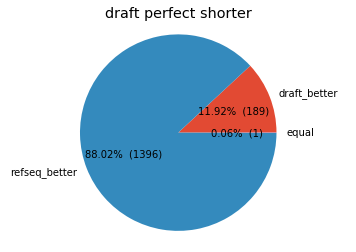

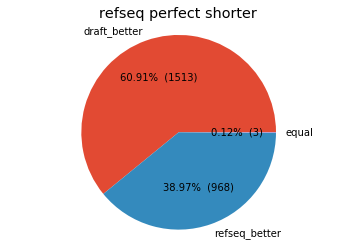

In [28]:
df = merge_short_dft2ref_mouse_df['refseq_good'].value_counts()
df = df.loc[[-1, 1, 0]]
sizes = np.array(df.tolist())
print df  
labels = ['draft_better','refseq_better','equal']
_ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.title('draft perfect shorter')

plt.figure()
df = merge_long_dft2ref_mouse_df['refseq_good'].value_counts()
df = df.loc[[-1, 1, 0]]
sizes = np.array(df.tolist())
print df  # need to check the index, then decide the order of df.index
labels = ['draft_better','refseq_better','equal']
_ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.title('refseq perfect shorter')

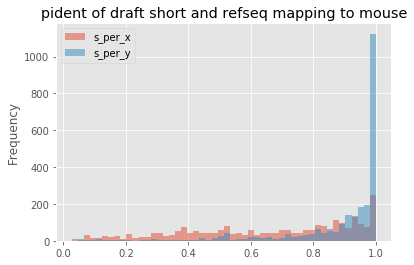

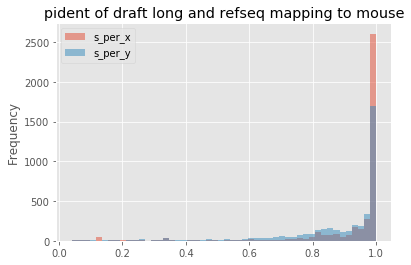

In [29]:
# mapping draft and refseq to mouse and get the 
refseq2mouse_df = get_pr_map_df(ref2mouse_fn, ref_pr_len_dic.keys())
refseq2mouse_df = get_best_hit(refseq2mouse_df)
draft2mouse_df = get_pr_map_df(dft2mouse_fn, draft_iso_short_no_perfect_prs)
draft2mouse_df = get_best_hit(draft2mouse_df)
ax = (pd.merge(draft2mouse_df, refseq2mouse_df, on=['ref','slen'],how='inner'))[['s_per_x','s_per_y']].plot(kind='hist', bins=50, alpha=0.5)
_ = ax.set_title('pident of draft short and refseq mapping to mouse')
draft2mouse_df = get_pr_map_df(dft2mouse_fn, draft_iso_long_no_perfect_prs)
draft2mouse_df = get_best_hit(draft2mouse_df)
ax = (pd.merge(draft2mouse_df, refseq2mouse_df, on=['ref','slen'],how='inner'))[['s_per_x','s_per_y']].plot(kind='hist', bins=50, alpha=0.5)
_ = ax.set_title('pident of draft long and refseq mapping to mouse')

#### 2. Non perfect high quality mapping

In [30]:
fil_dft2ref_best_pr_df = get_best_hit(fil_dft2ref_pr_df)
fil_dft2ref_best_pr_df = fil_dft2ref_best_pr_df.query('query not in @one_side_perfect_dft_prs')
fil_dft2ref_best_pr_df = fil_dft2ref_best_pr_df.reset_index(drop=True)

In [31]:
high_qual_pr_df = fil_dft2ref_best_pr_df.query('(90 <= pident) & (evalue < 1e-20) & (q_per>= 0.8) & (s_per>=0.8)')
high_qual_draft_prs = high_qual_pr_df['query'].unique().tolist()
high_qual_ref_prs = high_qual_pr_df['ref'].unique().tolist()
high_qual_ref_genes = ref_id_df.query('PrAccess in @high_qual_ref_prs')['GeneID'].unique().tolist()
print 'high quality match to hamster refseq:', len(high_qual_draft_prs), 'draft prs mapping to', \
    len(high_qual_ref_prs), 'refseq prs', len(high_qual_ref_genes), 'refseq genes'
print 'cover', len(set(high_qual_ref_genes + perfect_ref_genes + one_side_perfect_ref_genes)), 'refseq genes'

high quality match to hamster refseq: 11780 draft prs mapping to 7525 refseq prs 6583 refseq genes
cover 17384 refseq genes


In [32]:
dft_only_high_qual_pr_df = fil_dft2ref_best_pr_df.query('(90 <= pident) & (evalue < 1e-20) & (q_per>= 0.8) & (s_per<0.8)')
dft_only_high_qual_draft_prs = dft_only_high_qual_pr_df['query'].unique().tolist()
dft_only_high_qual_ref_prs = dft_only_high_qual_pr_df['ref'].unique().tolist()
print 'draft only high quality mapping to hamster refseq:', len(dft_only_high_qual_draft_prs)
ref_only_high_qual_pr_df = fil_dft2ref_best_pr_df.query('(90 <= pident) & (evalue < 1e-20) & (q_per < 0.8) & (s_per>=0.8)')
ref_only_high_qual_draft_prs = ref_only_high_qual_pr_df['query'].unique().tolist()
ref_only_high_qual_ref_prs = ref_only_high_qual_pr_df['ref'].unique().tolist()
print 'draft only high quality mapping to hamster refseq:', len(ref_only_high_qual_draft_prs)

draft only high quality mapping to hamster refseq: 5426
draft only high quality mapping to hamster refseq: 1262


-1    7232
 1    4393
 0     117
Name: refseq_good, dtype: int64


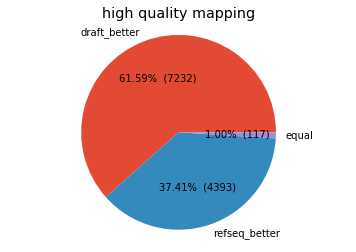

In [33]:
merge_dft_ref2mouse_df = get_merge_draft_refseq2mouse(fil_dft2ref_best_pr_df, dft2mouse_fn, ref2mouse_fn, high_qual_draft_prs, ref_pr_len_dic)
df = merge_dft_ref2mouse_df['refseq_good'].value_counts()
df = df.loc[[-1, 1, 0]]
sizes = np.array(df.tolist())
print df  # need to check the index, then decide the order of df.index
labels = ['draft_better','refseq_better','equal']
_ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.title('high quality mapping')

-1     367
 1    5014
Name: refseq_good, dtype: int64


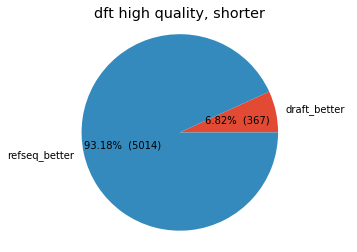

In [34]:
merge_dft_ref2mouse_df = get_merge_draft_refseq2mouse(fil_dft2ref_best_pr_df, dft2mouse_fn, ref2mouse_fn, dft_only_high_qual_draft_prs, ref_pr_len_dic)
df = merge_dft_ref2mouse_df['refseq_good'].value_counts()
df = df.loc[[-1, 1]]
sizes = np.array(df.tolist())
print df  # need to check the index, then decide the order of df.index
labels = ['draft_better','refseq_better']
_ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.title('dft high quality, shorter')

-1    1064
 1     189
Name: refseq_good, dtype: int64


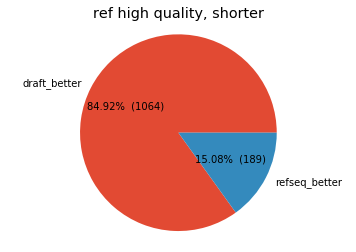

In [35]:
merge_dft_ref2mouse_df = get_merge_draft_refseq2mouse(fil_dft2ref_best_pr_df, dft2mouse_fn, ref2mouse_fn, ref_only_high_qual_draft_prs, ref_pr_len_dic)
df = merge_dft_ref2mouse_df['refseq_good'].value_counts()
df = df.loc[[-1, 1]]
sizes = np.array(df.tolist())
print df  # need to check the index, then decide the order of df.index
labels = ['draft_better','refseq_better']
_ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.title('ref high quality, shorter')

### Till this step, we mapped 42666 draft protines, 89% of total, 85% refseq genes

### 3. Low quality mapping

In [36]:
mapped_prs = high_qual_draft_prs + dft_only_high_qual_draft_prs + ref_only_high_qual_draft_prs

In [37]:
low_qual_pr_df = fil_dft2ref_best_pr_df.query('query not in @mapped_prs')
low_qual_draft_prs = low_qual_pr_df['query'].unique().tolist()
low_qual_ref_prs = low_qual_pr_df['ref'].unique().tolist()
low_qual_ref_genes = ref_id_df.query('PrAccess in @low_qual_ref_prs')['GeneID'].unique().tolist()
print 'low quality match to hamster refseq:', len(low_qual_draft_prs), 'draft prs mapping to', \
    len(low_qual_ref_prs), 'refseq', len(low_qual_ref_genes), 'refseq genes'
print 'cover', len(set(low_qual_ref_genes+high_qual_ref_genes + perfect_ref_genes + one_side_perfect_ref_genes)), 'refseq genes'

low quality match to hamster refseq: 5820 draft prs mapping to 3100 refseq 2952 refseq genes
cover 18093 refseq genes


-1    1812
 1    3764
Name: refseq_good, dtype: int64


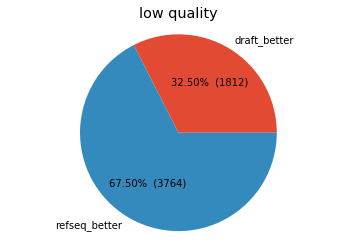

In [38]:
merge_dft_ref2mouse_df = get_merge_draft_refseq2mouse(fil_dft2ref_best_pr_df ,dft2mouse_fn, ref2mouse_fn, low_qual_draft_prs, ref_pr_len_dic)
df = merge_dft_ref2mouse_df['refseq_good'].value_counts()
df = df.loc[[-1, 1]]
sizes = np.array(df.tolist())
print df  # need to check the index, then decide the order of df.index
labels = ['draft_better','refseq_better']
_ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.title('low quality')

In [39]:
len(low_qual_draft_prs)

5820

There are some low qualities mappings map very well, just with not enough length.

### Till now, covers 91% refseq genes.

### 4. Non mapping proteins

In [121]:
non_map_prs = list(set(dft_prs)-set(perfect_draft_proteins)-set(one_side_perfect_dft_prs)-set(high_qual_draft_prs)-\
                   set(dft_only_high_qual_draft_prs)-set(ref_only_high_qual_draft_prs)-set(low_qual_draft_prs))

In [122]:
len(non_map_prs)

271

### Analyze draft protein mapping to nicole hamster

In [40]:
dft2chr_fn = path + '/13_draft2nicole.txt'
dft2chr_df = get_pr_map_df(dft2chr_fn, dft_pr_len_dic.keys(), dft_pr_len_dic)

In [41]:
nicole_prs = dft2chr_df.query('(query in @low_qual_draft_prs) & (pident >= 90) & ((q_per >= 0.8) & (s_per >= 0.8))')['query'].unique().tolist()
print len(nicole_prs)
nicole_prs1 = dft2chr_df.query('(query in @low_qual_draft_prs) & (pident >= 90) & ((q_per >= 0.8) & (s_per < 0.8))')['query'].unique().tolist()
print len(nicole_prs1)
nicole_prs2 = dft2chr_df.query('(query in @low_qual_draft_prs) & (pident >= 90) & ((q_per < 0.8) & (s_per >= 0.8))')['query'].unique().tolist()
print len(nicole_prs2)

684
579
443


### Analyze draft protein mapping to CHOK1 proteins

In [42]:
# read draft proetin mapping to chok1
dft2k1_fn = path + '/14_draft2chok1.txt'
dft2k1_df = get_pr_map_df(dft2k1_fn, dft_pr_len_dic.keys(), dft_pr_len_dic)

In [43]:
k1_prs = dft2k1_df.query('(query in @low_qual_draft_prs) & (pident >= 90) & ((q_per >= 0.8) & (s_per >= 0.8))')['query'].unique().tolist()
print len(k1_prs)
k1_prs1 = dft2k1_df.query('(query in @low_qual_draft_prs) & (pident >= 90) & ((q_per >= 0.8) & (s_per < 0.8))')['query'].unique().tolist()
print len(k1_prs1)
k1_prs2 = dft2k1_df.query('(query in @low_qual_draft_prs) & (pident >= 90) & ((q_per < 0.8) & (s_per >= 0.8))')['query'].unique().tolist()
print len(k1_prs2)

776
415
288


In [44]:
other_high_qual_prs = list(set(nicole_prs + k1_prs))
print len(other_high_qual_prs)
other_dft_only_high_qual_prs = list(set(nicole_prs1 + k1_prs1) - set(other_high_qual_prs))
print len(other_dft_only_high_qual_prs)
other_ref_only_high_qual_prs = list(set(nicole_prs2 + k1_prs2) - set(other_high_qual_prs) - set(other_dft_only_high_qual_prs))
print len(other_ref_only_high_qual_prs)

1153
772
493


In [45]:
final_left_prs  = list(set(low_qual_draft_prs) - set(other_high_qual_prs) - set(other_dft_only_high_qual_prs)
                      - set(other_ref_only_high_qual_prs))

print 'there are', len(final_left_prs), 'low quality protein mappings'

there are 3402 low quality protein mappings


In [46]:
low_qual_iso_perfect_prs = find_iso_perfect(low_qual_draft_prs, perfect_draft_proteins, dft_rna_gid_dic, dft_gid_rna_dic)
test = find_iso_perfect(low_qual_draft_prs, high_qual_draft_prs, dft_rna_gid_dic, dft_gid_rna_dic)
test1 = find_iso_perfect(low_qual_draft_prs, dft_only_high_qual_draft_prs, dft_rna_gid_dic, dft_gid_rna_dic)
test2 = find_iso_perfect(low_qual_draft_prs, ref_only_high_qual_draft_prs, dft_rna_gid_dic, dft_gid_rna_dic)
len(set(test2) - set(test1) - set(test)-set(low_qual_iso_perfect_prs))

116

In [48]:
geneids = dft_pr_id_df.query('rna_id in @final_left_prs')
# dft_pr_id_df.query('')

### 4. Check how many draft genes have peptides support

In [49]:
def add_geneid_pepnum(pep_pos_fn,rna_gene_dic):
    ''' add geneid, and number of genes each peptide map to
    pep_pos_fn: 4 columns [rna, pep, pos, spec_num]. 
    rna_gene_dic: {rnaid, geneid}
    '''
    # analyze known peptides
    pep_pos_df = pd.read_csv(pep_pos_fn,sep='\t',header=0,names=['pr','pep','pos','spec_num'])
    pep_pos_df['pr'] = pep_pos_df['pr'].map(lambda x: x.split('.')[0])
    pep_pos_df['geneid'] = pep_pos_df['pr'].map(lambda x:rna_gene_dic[x])
    # get {pep: number of genes mapped to}
    pep_gene_dic = pep_pos_df[['pep','geneid']].drop_duplicates().groupby('pep').count().to_dict()['geneid']
    pep_pos_df['pep_num_gene'] = pep_pos_df['pep'].map(lambda x: pep_gene_dic[x])
    return pep_pos_df

In [50]:
dft_known_pos_fn = '/data/shangzhong/Proteogenomics/event_results/draft_pos.txt'
ref_known_pos_fn = '/data/shangzhong/Proteogenomics/event_results/ref_pos.txt'
dft_known_pos_df = add_geneid_pepnum(dft_known_pos_fn,dft_rna_gid_dic)
ref_known_pos_df = add_geneid_pepnum(ref_known_pos_fn,ref_pr_gid_dic)

In [126]:
def get_pr_pos_dic(df):
    '''build dictionary {pr: {pep : num of location}}
    '''
    dft_pr_pos_dic = {}
    for idx, row in df.iterrows():
        pr = row['pr']
        pep = row['pep']
        num = row['pep_num_gene']
        if pr not in dft_pr_pos_dic:
            dft_pr_pos_dic[pr] = {pep:num}
        else:
            dft_pr_pos_dic[pr][pep] = num
    # get proteins with at least two peptides and at least one unique peptides
    filter_dic = {}
    for k,v in dft_pr_pos_dic.iteritems():
        if len(v) < 2:
            continue
        else:
            values = v.values()
            if 1 not in values:
                continue
        filter_dic[k] = v
    print len(dft_pr_pos_dic)
    print len(filter_dic)
    return filter_dic

dft_pr_pos_dic = get_pr_pos_dic(dft_known_pos_df)
ref_pr_pos_dic = get_pr_pos_dic(ref_known_pos_df)

27732
21420
27102
22945


In [127]:
def score_draft_pr(df, dft_pr_pos_dic, ref_pr_pos_dic):
    '''give the draft proteins score.
    1: means draft has unique peptides
    2: means draft has multiple peptides
    3: means ref has unique peptides
    4: means ref has multiple peptides
    5: means draft and ref have same peptides
    6: means draft and ref both have unique peptides
    7: means draft has unique, refseq has multi mapped
    8: means draft has multi, refseq has unique
    '''
    dft_ref_pr_dic = df.set_index('query')['ref'].to_dict()
    pr_type_dic = {}
    pr_no_pep = []
    for pr in sorted(dft_ref_pr_dic.keys()):
        ref = dft_ref_pr_dic[pr]
        try:
            dft_peps = dft_pr_pos_dic[pr].keys()
            ref_peps = ref_pr_pos_dic[ref].keys()
        except:
            pr_no_pep.append(pr)
            continue
        dft_uni = set(dft_peps) - set(ref_peps)
        ref_uni = set(ref_peps) - set(dft_peps)
        if dft_uni != set() and ref_uni != set():
            dft_nums = [dft_pr_pos_dic[pr][dft] for dft in dft_uni]
            ref_nums = [ref_pr_pos_dic[ref][p] for p in ref_uni]
            if 1 in dft_nums and 1 in ref_nums:
                pr_type_dic[pr] = 6
            elif 1 in dft_nums and 1 not in ref_nums:
                pr_type_dic[pr] = 7
            elif 1 not in dft_nums and 1 in ref_nums:
                pr_type_dic[pr] = 8
        else:
            if dft_uni != set():
                dft_nums = [dft_pr_pos_dic[pr][dft] for dft in dft_uni]
                if 1 in dft_nums:
                    pr_type_dic[pr] = 1
                else:
                    pr_type_dic[pr] = 2
            else:
                if ref_uni != set():
                    ref_nums = [ref_pr_pos_dic[ref][p] for p in ref_uni]
                    if 1 in ref_nums:
                        pr_type_dic[pr] = 3
                    else:
                        pr_type_dic[pr] =  4
                else:
                    pr_type_dic[pr] = 5
    return pr_type_dic, pr_no_pep

perfect_draft_only_pr_score, draft_no_peps = score_draft_pr(draft_iso_short_no_perfect_df, dft_pr_pos_dic, ref_pr_pos_dic)
perfect_ref_only_pr_score, ref_no_peps = score_draft_pr(draft_iso_long_no_perfect_df, dft_pr_pos_dic, ref_pr_pos_dic)
high_qual_pr_score, high_qual_no_peps = score_draft_pr(high_qual_pr_df, dft_pr_pos_dic, ref_pr_pos_dic)
dft_high_qual_pr_score, dft_high_qual_no_peps = score_draft_pr(dft_only_high_qual_pr_df, dft_pr_pos_dic, ref_pr_pos_dic)
ref_high_qual_pr_score, ref_high_qual_no_peps = score_draft_pr(ref_only_high_qual_pr_df, dft_pr_pos_dic, ref_pr_pos_dic)
low_qual_pr_score, low_qual_no_peps = score_draft_pr(low_qual_pr_df, dft_pr_pos_dic, ref_pr_pos_dic)

dft_pft_sc = pd.DataFrame(perfect_draft_only_pr_score.items(),columns=['pr','num'])['num'].value_counts().sort_index()
ref_pft_sc = pd.DataFrame(perfect_ref_only_pr_score.items(),columns=['pr','num'])['num'].value_counts().sort_index()
high_qual_sc = pd.DataFrame(high_qual_pr_score.items(),columns=['pr','num'])['num'].value_counts().sort_index()
dft_high_qual_sc = pd.DataFrame(dft_high_qual_pr_score.items(),columns=['pr','num'])['num'].value_counts().sort_index()
ref_high_qual_sc = pd.DataFrame(ref_high_qual_pr_score.items(),columns=['pr','num'])['num'].value_counts().sort_index()
low_qual_sc = pd.DataFrame(low_qual_pr_score.items(),columns=['pr','num'])['num'].value_counts().sort_index()

score_df = pd.concat([dft_pft_sc, ref_pft_sc, high_qual_sc, dft_high_qual_sc, ref_high_qual_sc, low_qual_sc], axis=1)
score_df.columns = ['dft_perfect_short','refseq_perfect_short','high_qual', 'dft_high_qual', 'ref_high_qual','low_qual']

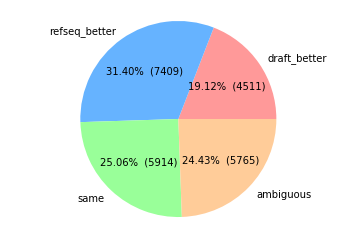

In [403]:
sizes = np.array([4652, 6492, 7856, 4808])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = ['draft_better','refseq_better','same','ambiguous']
_ = _ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes), colors=colors)
_ = plt.axis('equal')

In [128]:
# for prs have at least 2 proteins and with one 
score_df['sum'] = score_df.sum(axis=1)
score_df

,dft_perfect_short,refseq_perfect_short,high_qual,dft_high_qual,ref_high_qual,low_qual,sum
1,NaN,602.0,2310,99,487,392,3890.0
2,NaN,27.0,122,3,19,16,187.0
3,536.0,NaN,1210,2099,46,661,4552.0
4,9.0,NaN,51,31,2,5,98.0
5,296.0,1019.0,3666,265,154,208,5608.0
6,NaN,NaN,1462,720,167,1255,3604.0
7,NaN,NaN,33,12,3,14,62.0
8,NaN,NaN,77,29,3,33,142.0


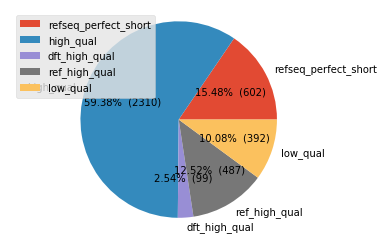

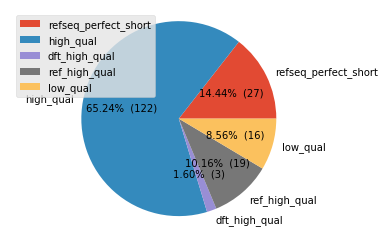

In [7]:
sizes = np.array([602, 2310, 99, 487, 392])
labels = ['refseq_perfect_short', 'high_qual', 'dft_high_qual', 'ref_high_qual','low_qual']
_ = _ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.legend()
plt.savefig('/data/shangzhong/1.svg')

plt.figure()
sizes = np.array([27, 122, 3, 19, 16])
labels = ['refseq_perfect_short', 'high_qual', 'dft_high_qual', 'ref_high_qual','low_qual']
_ = _ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
_ = plt.axis('equal')
_ = plt.legend()
plt.savefig('/data/shangzhong/2.svg')


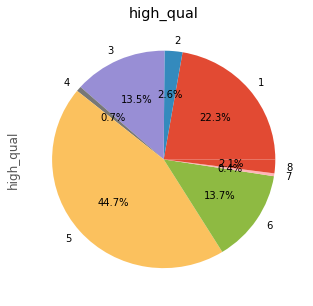

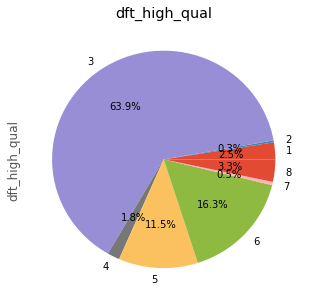

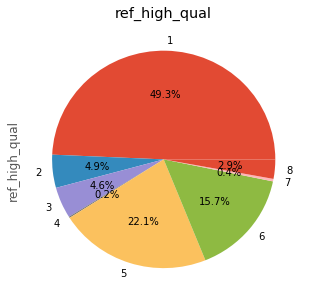

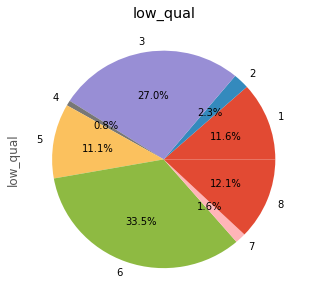

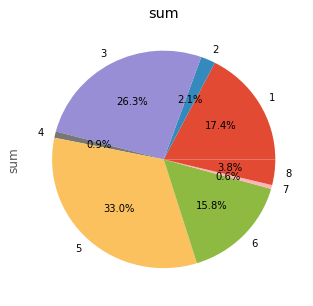

In [64]:
for col in score_df.columns[2:]:
    plt.figure(figsize=(5,5))
    ax = score_df[col].plot(kind='pie',autopct='%.1f%%', rot=0)
    plt.title(col)
    plt.savefig(path + '/' + col+'.svg')
# for col in score_df.columns[2:]:
#     plt.figure()
#     sizes = np.array(score_df[col].tolist())
#     labels = ['1','2','3','4','5','6','7','8']
#     _ = _ = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes))
#     _ = plt.axis('equal')
#     _ = plt.title(col)
#     plt.savefig(path + '/' + col + '.svg')

### Figure out why there is low mapping between draft annotation and refseq
1. One possible reason is that the genes locate in gap regions, event though refseq updates the sequence, but maybe not accurate enough, os we check how many of each category have gap regions.

In [66]:
# 1. get all gaps regions in picr
gap_fn = path + '/filter_all_gap.txt'
gap_df = pd.read_csv(gap_fn, sep='\t', header=0)
gap_bed = BedTool.from_dataframe(gap_df[['ref','r_s','r_e']])
# 2. get all CDS regions in draft annotation
draft_gff_df = pd.read_csv(dft_gff_fn, sep='\t', header=None)
dft_pr_gff_df = draft_gff_df[draft_gff_df[2].values=='CDS']
dft_pr_gff_df = dft_pr_gff_df.reset_index(drop=True)
dft_pr_gff_df['pr'] = dft_pr_gff_df[8].map(lambda x: re.search('(?<=Parent=).+?(?=;)',x).group(0))
dft_pr_gff_df['cds_idx'] = dft_pr_gff_df[8].map(lambda x: re.search('(?<=.cds).+?(?=;)', x).group(0))
dft_gff_bed = BedTool.from_dataframe(dft_pr_gff_df[[0, 3, 4, 'pr','cds_idx']].drop_duplicates())
# 3. overlap gap and CDS region
dft_gap_df = dft_gff_bed.intersect(gap_bed, wo=True).to_dataframe(names=['anno_chr','anno_s','anno_e','pr','cds_idx',
                                                    'gap_chr','gap_s','gap_e','len'])
dft_gap_df['anno_pct'] = dft_gap_df['len'] / (dft_gap_df['anno_e'] - dft_gap_df['anno_s'])
gap_prs = dft_gap_df['pr'].unique().tolist()
print 'there are', len(gap_prs), 'proteins have gaps'

there are 6130 proteins have gaps


In [67]:
pr_gap_len_df = dft_gap_df.groupby('pr', as_index=False)['len'].sum()
# pr_gap_len_df.query('pr in @low_qual_draft_prs')['len'].plot(kind='hist')

In [68]:
print len(set(gap_prs).intersection(perfect_draft_proteins))
print len(set(gap_prs).intersection(draft_iso_short_no_perfect_prs))
print len(set(gap_prs).intersection(draft_iso_long_no_perfect_prs))
print len(set(gap_prs).intersection(high_qual_draft_prs))
print len(set(gap_prs).intersection(dft_only_high_qual_draft_prs))
print len(set(gap_prs).intersection(ref_only_high_qual_draft_prs))
print len(set(gap_prs).intersection(low_qual_draft_prs))

261
27
281
2410
515
255
854


In [69]:
ref2dft_fn = path + '/12_refseq2draft.txt'
ref2dft_df = get_pr_map_df(ref2dft_fn, ref_pr_len_dic.keys(), ref_pr_len_dic)

2. check if 9% left refseq genes have peptides mapping

In [71]:
verified_ref_genes = list(set(low_qual_ref_genes + high_qual_ref_genes + perfect_ref_genes + one_side_perfect_ref_genes))
left_ref_genes = list(set(ref_genes) - set(verified_ref_genes))
print len(left_ref_genes), 'refseq genes do not have mapping'

2257 refseq genes do not have mapping


In [79]:
print ref_known_pos_df.query('geneid in @left_ref_genes')['geneid'].unique().size, 'left refseq genes have peptides', \
ref_known_pos_df.query('(geneid in @left_ref_genes) & (pep_num_gene==1)')['geneid'].unique().size, 'of them have unique peptides'

1135 left refseq genes have peptides 929 of them have unique peptides
